# Work out where the channel could be

Because radar just shows distance not location

There are many possibilities given our radar lines.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
import rasterio as rio

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed_depth.shp')

In [3]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()

In [4]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].reset_index(drop=True).copy()
    add_distance_to_gdf(ll[line])

In [5]:
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

# Get points in centre of each line

In [6]:
cross_channel_lines = ['line7p75','line7','line4','line5', 'line6', 'line7p25', 'line7p5', 'line7p75','lineback2camp']

In [7]:
#lines which cross the channel
cl  = {key:value for key,value in ll.items() if key in cross_channel_lines}

In [8]:
#get the index of each channel min
channel_mins = {key:value.ice_thickn.idxmin() for key,value in cl.items()}
channel_mins

{'line7': 318,
 'line4': 778,
 'line6': 883,
 'line7p25': 182,
 'line7p5': 467,
 'line7p75': 463,
 'lineback2camp': 207,
 'line5': 753}

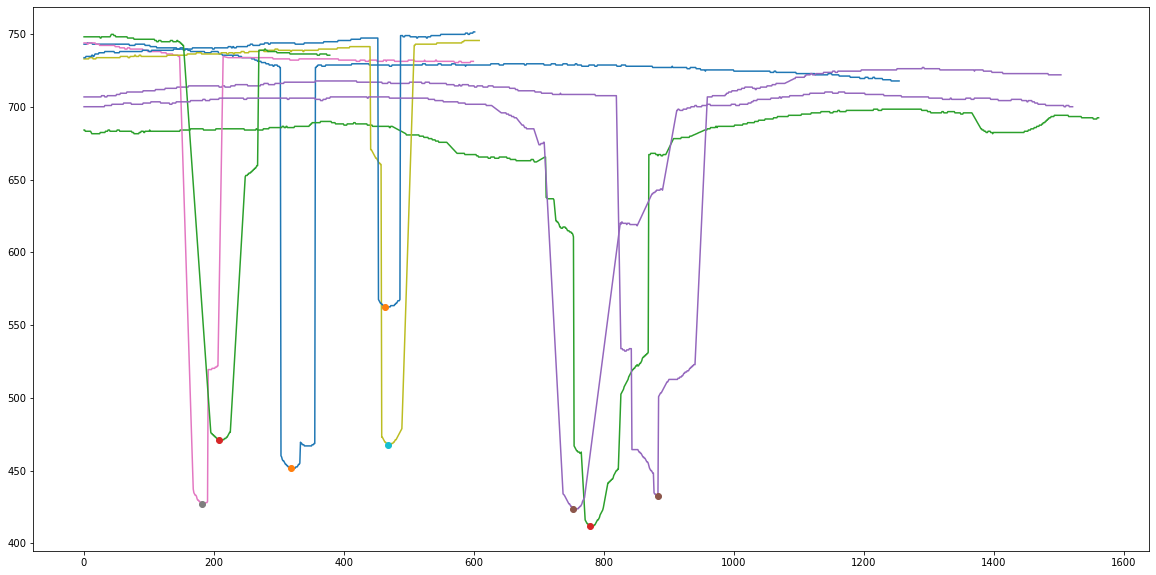

In [9]:
#double check the mins are chosen properly

plt.figure(figsize=(20,10))

for key,value in channel_mins.items():
    plt.plot(cl[key].ice_thickn)
    plt.plot(value,cl[key].ice_thickn.loc[value],'o')

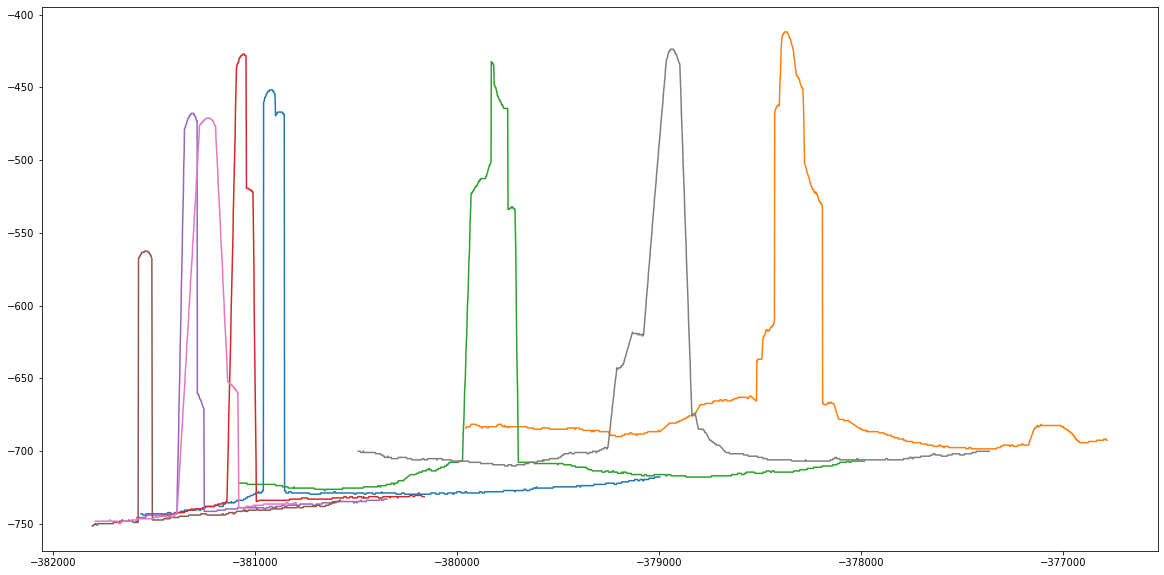

In [10]:
#plotted channel profiles to compare the notches

plt.figure(figsize=(20,10))

for key,value in channel_mins.items():
    plt.plot(cl[key].x,-cl[key].ice_thickn)

In [11]:
channelmin_indicies = {}
for line in cross_channel_lines:
    channelmin_indicies[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].ice_thickn.idxmin()

In [12]:
chan_mins = bed_gdf.loc[list(channelmin_indicies.values())].copy()


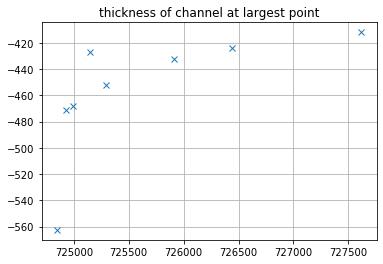

In [13]:
plt.plot(-chan_mins.y,0-chan_mins.ice_thickn,'x')
plt.grid()
plt.title('thickness of channel at largest point')
plt.show()

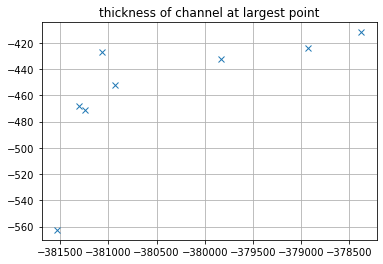

In [14]:
plt.plot(chan_mins.x,0-chan_mins.ice_thickn,'x')
plt.grid()
plt.title('thickness of channel at largest point')
plt.show()

# make an along track distance, down the middle of channel

In [15]:
chan_mins.sort_values(by='x',inplace=True)

In [16]:
chan_mins

,CDP,x,y,DELAY,line_name,SEQnum,camp,ice_thickn,geometry
27205,563,-381532.2,-724845.1,6650,line7p75,18,KIS2,562.541990,POINT (-381532.200 -724845.100)
26600,567,-381304.7,-724992.9,5530,line7p5,17,KIS2,467.838121,POINT (-381304.700 -724992.900)
33481,307,-381242.8,-724929.3,5570,lineback2camp,22,KIS2,471.224770,POINT (-381242.800 -724929.300)
25715,282,-381061.5,-725146.6,5050,line7p25,16,KIS2,427.164947,POINT (-381061.500 -725146.600)
318,418,-380927.7,-725292.4,5340,line7,1,KIS2,451.746014,POINT (-380927.700 -725292.400)
24912,983,-379830.0,-725908.3,5110,line6,15,KIS2,432.252773,POINT (-379830.000 -725908.300)
77586,853,-378929.1,-726440.5,5010,line5,49,KIS2,423.772418,POINT (-378929.100 -726440.500)
20300,878,-378377.4,-727618.8,4870,line4,13,KIS2,411.894294,POINT (-378377.400 -727618.800)


In [17]:
tmp = chan_mins.loc[33481].copy()

In [18]:
chan_mins.drop(index=33481,inplace=True)


In [19]:
chan_mins.reset_index(inplace=True,drop=True)

In [20]:
add_distance_to_gdf(chan_mins)

In [21]:
chan_mins

,CDP,x,y,DELAY,line_name,SEQnum,camp,ice_thickn,geometry,dx,distan_cum
0,563,-381532.2,-724845.1,6650,line7p75,18,KIS2,562.541990,POINT (-381532.200 -724845.100),0.000000,0.000000
1,567,-381304.7,-724992.9,5530,line7p5,17,KIS2,467.838121,POINT (-381304.700 -724992.900),271.295208,271.295208
2,282,-381061.5,-725146.6,5050,line7p25,16,KIS2,427.164947,POINT (-381061.500 -725146.600),287.697636,558.992845
3,418,-380927.7,-725292.4,5340,line7,1,KIS2,451.746014,POINT (-380927.700 -725292.400),197.889060,756.881904
4,983,-379830.0,-725908.3,5110,line6,15,KIS2,432.252773,POINT (-379830.000 -725908.300),1258.681095,2015.563000
5,853,-378929.1,-726440.5,5010,line5,49,KIS2,423.772418,POINT (-378929.100 -726440.500),1046.354457,3061.917457
6,878,-378377.4,-727618.8,4870,line4,13,KIS2,411.894294,POINT (-378377.400 -727618.800),1301.062558,4362.980015


In [22]:
tmp.drop(columns='lineback2camp',inplace=True)

In [23]:
chan_mins.loc['lineback2camp'] = tmp

In [24]:
chan_mins

,CDP,x,y,DELAY,line_name,SEQnum,camp,ice_thickn,geometry,dx,distan_cum
0,563,-381532.2,-724845.1,6650,line7p75,18,KIS2,562.541990,POINT (-381532.200 -724845.100),0.000000,0.000000
1,567,-381304.7,-724992.9,5530,line7p5,17,KIS2,467.838121,POINT (-381304.700 -724992.900),271.295208,271.295208
2,282,-381061.5,-725146.6,5050,line7p25,16,KIS2,427.164947,POINT (-381061.500 -725146.600),287.697636,558.992845
3,418,-380927.7,-725292.4,5340,line7,1,KIS2,451.746014,POINT (-380927.700 -725292.400),197.889060,756.881904
4,983,-379830.0,-725908.3,5110,line6,15,KIS2,432.252773,POINT (-379830.000 -725908.300),1258.681095,2015.563000
5,853,-378929.1,-726440.5,5010,line5,49,KIS2,423.772418,POINT (-378929.100 -726440.500),1046.354457,3061.917457
6,878,-378377.4,-727618.8,4870,line4,13,KIS2,411.894294,POINT (-378377.400 -727618.800),1301.062558,4362.980015
lineback2camp,307,-381242.8,-724929.3,5570,lineback2camp,22,KIS2,471.224770,POINT (-381242.800 -724929.300),NaN,NaN


In [26]:
#  # lineback2camp is off to the side so we treat it different
chan_mins.loc['lineback2camp','dx'] = chan_mins.loc['lineback2camp'].geometry.distance(chan_mins.geometry.loc[0]) 
chan_mins.loc['lineback2camp','distan_cum'] = chan_mins.loc['lineback2camp'].geometry.distance(chan_mins.geometry.loc[0]) 

In [27]:
chan_mins.sort_values(by='distan_cum',inplace=True)

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


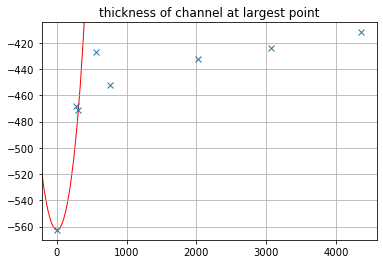

In [28]:
fig, ax = plt.subplots()
plt.Circle((0, 0), 400,fill=False)



circle1 = plt.Circle((0, 0), chan_mins.ice_thickn.iloc[0], color='r',Fill=False)

ax.add_artist(circle1)

ax.plot(chan_mins.distan_cum,0-chan_mins.ice_thickn,'x')
ax.grid()
ax.set_title('thickness of channel at largest point')
fig.show()

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


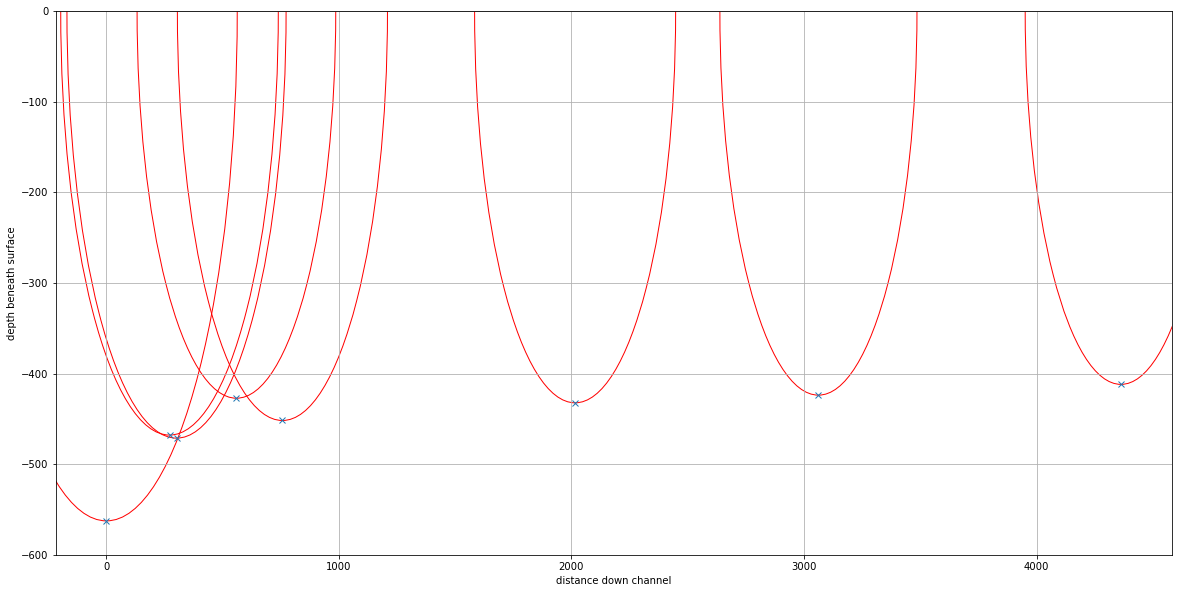

In [29]:
fig, ax = plt.subplots(figsize=(20,10))

for i,row in chan_mins.iterrows():
    circle = plt.Circle((row.distan_cum,0), row.ice_thickn, color='r',Fill=False)
    ax.add_artist(circle)

ax.plot(chan_mins.distan_cum,0-chan_mins.ice_thickn,'x')
ax.grid()
ax.set_xlabel('distance down channel')
ax.set_ylabel('depth beneath surface')
ax.set_ylim([-600,0])
fig.show()

# What i'm thinkin

Im trying to work out if we can learn something about where the channel is. 

The intersections of these lines are possible locations of reflections.

There are many possibilities given our radar lines.

It seems likely that the channel starts where the double dots are.

Other alternatives are that it starts earlier, shallower, but seems a coincidence that the circle exactly intersects the next point.

There are no other real intersections of three circles

Should really do it in 3D

In [30]:
def plot_sphere(axes,centre,radius):

    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = centre[0] + radius *  np.cos(u)*np.sin(v)
    y = centre[1] + radius *np.sin(u)*np.sin(v)
    z =  centre[2] + radius * np.cos(v)

    axes.plot_surface(x, y, z, alpha=0.4)


In [31]:
%matplotlib qt5
fig = plt.figure()
ax = plt.axes(projection='3d')
plot_sphere(ax,centre = [0,0,0],radius =5)

In [32]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

for i,row in chan_mins.iterrows():
    plot_sphere(ax,centre = [row.x,row.y,0],radius=row.ice_thickn)

ax.scatter(chan_mins.x,chan_mins.y,-chan_mins.ice_thickn)
fig.show()

In [33]:
%matplotlib qt5
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

for i,row in chan_mins.iloc[:4].iterrows():
    plot_sphere(ax,centre = [row.x,row.y,0],radius=row.ice_thickn)

ax.scatter(chan_mins.iloc[:4].x,chan_mins.iloc[:4].y,-chan_mins.iloc[:4].ice_thickn)
fig.show()

In [34]:
chan_mins

,CDP,x,y,DELAY,line_name,SEQnum,camp,ice_thickn,geometry,dx,distan_cum
0,563,-381532.2,-724845.1,6650,line7p75,18,KIS2,562.541990,POINT (-381532.200 -724845.100),0.000000,0.000000
1,567,-381304.7,-724992.9,5530,line7p5,17,KIS2,467.838121,POINT (-381304.700 -724992.900),271.295208,271.295208
lineback2camp,307,-381242.8,-724929.3,5570,lineback2camp,22,KIS2,471.224770,POINT (-381242.800 -724929.300),301.400066,301.400066
2,282,-381061.5,-725146.6,5050,line7p25,16,KIS2,427.164947,POINT (-381061.500 -725146.600),287.697636,558.992845
3,418,-380927.7,-725292.4,5340,line7,1,KIS2,451.746014,POINT (-380927.700 -725292.400),197.889060,756.881904
4,983,-379830.0,-725908.3,5110,line6,15,KIS2,432.252773,POINT (-379830.000 -725908.300),1258.681095,2015.563000
5,853,-378929.1,-726440.5,5010,line5,49,KIS2,423.772418,POINT (-378929.100 -726440.500),1046.354457,3061.917457
6,878,-378377.4,-727618.8,4870,line4,13,KIS2,411.894294,POINT (-378377.400 -727618.800),1301.062558,4362.980015


In [35]:
chan_mins.shape


(8, 11)

In [36]:
#distance between a reciever point on the surface and the other points underground
distances = []
for i in range(8):
    pt_surf = np.array([chan_mins.x.iloc[i],chan_mins.y.iloc[i],0])
    distance = []
    for j in range(8):
        pt_underground = np.array([chan_mins.x.iloc[j],chan_mins.y.iloc[j],chan_mins.ice_thickn.iloc[j]])
        distance.append( np.linalg.norm( pt_surf - pt_underground) )
    distances.append( distance)

In [37]:
chan_mins['distances'] = distances

In [38]:
for i,row in chan_mins.iterrows():
    print(np.array(row.distances) - row.ice_thickn)

[ 0.00000000e+00 -2.17337090e+01 -3.17200168e+00  1.40971074e+02
  3.14710539e+02  1.49043671e+03  2.51982947e+03  3.65833844e+03]
[ 156.70537735    0.           11.67137272   47.17626973  192.39192321
 1320.88760156 2346.16333319 3486.15897206]
[ 166.97229235    4.95699861    0.           41.18021817  188.47522265
 1301.14293957 2324.57854748 3480.17805888]
[ 365.87618068  122.05489664  122.5092872     0.           66.02319196
 1084.00069516 2102.83308266 3245.13985462]
[ 487.37646552  219.59723472  221.44222468   19.02991216    0.
  879.08852129 1891.78095064 3024.72115278]
[1652.05348381 1365.40396793 1350.02038937 1077.46542363  905.04022469
    0.          696.65852254 1849.30676401]
[2680.72178537 2397.20146086 2379.61587339 2106.79606765 1924.97406241
  708.34953158    0.          940.93293066]
[3826.33979805 3548.32143313 3546.13301673 3262.15463609 3069.5194288
 1873.42832403  956.44296045    0.        ]


In [39]:
chan_mins.index

Index([0, 1, 'lineback2camp', 2, 3, 4, 5, 6], dtype='object')

The rows and columns above are the 8 ordered lines, the low numbers are when they could be sharing point sources.

ie 'line7p75', 'line7p5', 'lineback2camp' could all be pinging off each other

'line7p5', 'lineback2camp', and maybe but less so 'line7p25'